# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU. 

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
#! wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#    -O ./cats_and_dogs_filtered.zip

In [2]:
%%capture
# ! unzip cats_and_dogs_filtered.zip 

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [3]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring. 

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test. 

In [4]:
import torch
from torch.utils.data import Dataset, IterableDataset
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
import math
import os, datetime
from pathlib import Path

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

In [5]:
class MultipleImageTransforms(IterableDataset):
    def __init__(self, dataset, num_samples, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dataset = dataset
        self.num_samples = num_samples
    
    # def __len__(self):
    #    return len(self.dataset)*self.num_samples

    # def __get__(self, idx):
    #     images = []
    #     labels = []
    #     for _ in range(self.num_samples):
    #         image, label = self.dataset[idx]
    #         images.append(image)
    #         labels.append(labels)
    #     return images, labels
    
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            iter_start = 0
            iter_end = len(self.dataset) - 1
        else:
            per_worker = int(math.ceil(
                len(self.dataset) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(self.dataset) - 1)
        
        def transform_iterator(start_idx, end_idx):
            for idx in range(start_idx, end_idx+1):
                for _ in range(self.num_samples):
                    yield self.dataset[idx]
    

        class ImageTransformIterator:
            def __init__(self, parent):
                self.parent = parent
                self.max = len(parent.dataset)
                self.idx = 0
                self.sample_idx = 0

            def __iter__(self):
                self.idx = 0
                self.sample_idx = 0
                return self
            
            def __next__(self):
                if self.idx < self.max:
                    ret = self.parent.dataset[self.idx]
                    self.sample_idx += 1
                    if self.sample_idx == self.parent.num_samples:
                        self.idx += 1
                    return ret
                raise StopIteration

        return transform_iterator(iter_start, iter_end)


In [6]:
new_validation_dataset = MultipleImageTransforms(
  validation_dataset, 5)
#next(new_validation_dataset)
len(next(iter(torch.utils.data.DataLoader(new_validation_dataset, batch_size=32, num_workers=2)))[0])

32

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

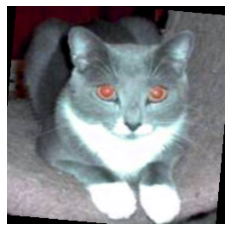

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[500][0])

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [8]:
train_dataset[1001][0].shape
type(train_dataset[0])

tuple

### Creating the model

In [9]:
from pickle import TRUE
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import gc


In [39]:

class ResBlock(nn.Module):
  def __init__(self, residual, skip, act=True):
    super().__init__()
    self.residual = residual
    self.skip = skip
    self.act = nn.ReLU() if act else nn.Identity()
  
  def forward(self, input):
    tmp = self.residual(input) + self.skip(input)
    tmp = self.act(tmp)
    return tmp

class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  
  def forward(self, input):
    return input.view(*self.shape)

class CNN(torch.nn.Module):
  # Input -> Conv -> BN -> ReLU -> Pooling -> Conv -> BN -> ReLU -> Pooling
  def __init__(
    self, in_channels=3, img_dim=256, n_features=32, kernel_size=3,
    add_res=False):
    super().__init__()
    self.in_channels = in_channels
    self.img_dim = img_dim
    self.n_features = n_features
    self.kernel_size = kernel_size
    self.add_res = add_res
  
    self.conv1 = self.conv(
      in_channels, n_features, kernel_size, stride=2, batch_norm=True)
    self.inter_dim = self.inter_layer_dim(
      self.img_dim, kernel_size, stride=2)
    print(f'1 Features in: {n_features} Features out: {n_features} '
      f'Inter dim: {self.inter_dim}')
    
    self.conv2 = self.conv(
      n_features, n_features, kernel_size, stride=1, batch_norm=True,
      pool=False)
    self.inter_dim = self.inter_layer_dim(
      self.inter_dim, kernel_size, stride=1)
    print(f'2 Features in: {n_features} Features out: {n_features} '
      f'Inter dim: {self.inter_dim}')

    self.conv3 = self.conv(
      n_features, n_features*2, kernel_size, stride=1, batch_norm=True,
      pool=True)
    self.inter_dim = self.inter_layer_dim(
      self.inter_dim, kernel_size, stride=1, pool_scale=2)
    n_features = n_features*2
    print(f'3 Features in: {n_features/2} Features out: {n_features} '
      f'Inter dim: {self.inter_dim}')

    # Res blocks
    if self.add_res:
      stride = 2
      self.res1 = self.res_layer(
        n_features, n_features, kernel_size, stride=stride, batch_norm=True)
      self.inter_dim = self.inter_layer_dim(
        self.inter_dim, kernel_size, stride=stride, pool_scale=1)
      print(f'4 Features in: {n_features} Features out: {n_features} '
        f'Inter dim: {self.inter_dim}')

      self.res2 = self.res_layer(
        n_features, n_features*2, kernel_size, stride=stride, batch_norm=True)
      self.inter_dim = self.inter_layer_dim(
        self.inter_dim, kernel_size, stride=stride)
      n_features *= 2
      print(f'5 Features in: {n_features//2} Features out: {n_features} '
        f'Inter dim: {self.inter_dim}')

      self.res3 = self.res_layer(
        n_features, n_features*2, kernel_size, stride=stride, batch_norm=True)
      self.inter_dim = self.inter_layer_dim(
        self.inter_dim, kernel_size, stride=stride)
      n_features *= 2
      print(f'6 Features in: {n_features//2} Features out: {n_features} '
        f'Inter dim: {self.inter_dim}')

      self.res4 = self.res_layer(
        n_features, n_features*2, kernel_size, stride=stride, batch_norm=True)
      self.inter_dim = self.inter_layer_dim(
        self.inter_dim, kernel_size, stride=stride)
      n_features *= 2
      print(f'7 Features in: {n_features//2} Features out: {n_features} '
        f'Inter dim: {self.inter_dim}')

    adaptive_pool = True
    if adaptive_pool:
        self.last_pool = nn.AdaptiveAvgPool2d(1)
        self.inter_dim = 1
    else:
      self.last_pool = nn.AvgPool2d(2)
      self.inter_dim = self.inter_layer_dim(
          self.inter_dim, kernel_size, pool_scale=2)
    fc_in = n_features * (self.inter_dim ** 2)
    print(f'Fully connected layer: {fc_in}')
    self.fc_ = self.fully_connected(fc_in)

  def inter_layer_dim(
    self, in_dim, kernel_size, stride=1, pad=True, dilation=1, pool_scale=1):
    padding = kernel_size//2 if pad else 0
    tmp = (in_dim + (2 * padding) - (dilation *(kernel_size - 1)) - 1) / stride
    return int(tmp + 1) //  pool_scale

  def fully_connected(self, n_in):
    fc1_out = int(np.ceil(np.sqrt(n_in)))
    fc2_out = int(np.ceil(np.sqrt(fc1_out)))
    fc3_out = 1
    return nn.Sequential(
      nn.Linear(n_in, fc1_out),
      nn.ReLU(),
      nn.Dropout(0.25),
      nn.Linear(fc1_out, fc3_out),
      #nn.ReLU(),
      #nn.Linear(fc2_out, fc3_out)
    )

  def conv(self, n_in, n_out, kernel_size, stride=1, pad=True, act=True,
      batch_norm=False, pool=False):
    padding = kernel_size // 2 if pad else 0
    layers = [
        nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_size,
        stride=stride, padding=padding)]
    if batch_norm:
      layers.append(nn.BatchNorm2d(n_out))
    if act:
      layers.append(nn.ReLU())
    if pool:
      layers.append(nn.MaxPool2d(kernel_size=2))
    
    return nn.Sequential(*layers)

  def conv_block(self, n_in, n_out, kernel_size, stride=1, pad=True, act=True,
    batch_norm=True, pool=False):
    return nn.Sequential(
      self.conv(
        n_in, n_out, kernel_size, stride=stride, act=act, pad=pad,
        pool=pool),
      self.conv(
        n_out, n_out, kernel_size, act=False, batch_norm=batch_norm),
    )
  
  def res_block(self, n_in, n_out, kernel_size, stride=1, pad=True, act=True,
    batch_norm=True, pool=False):
    residual = self.conv_block(
        n_in, n_out, kernel_size, stride=stride, pad=pad, act=act,
        batch_norm=batch_norm, pool=pool)
    skip = [nn.Identity()]
    if n_in != n_out:
      skip.append(self.conv(n_in, n_out, 1, act=False))
    if stride != 1:
      assert stride == 2
      skip.append(nn.AvgPool2d(2, ceil_mode=True))
    if pool:
      skip.append(nn.AvgPool2d(2, ceil_mode=True))
    skip = nn.Sequential(*skip)
    return ResBlock(residual, skip)

  def res_layer(self, n_in, n_out, kernel_size, stride=1, pad=True, act=True,
      batch_norm=True, pool=False):
    return nn.Sequential(
      self.res_block(
        n_in, n_out, kernel_size, stride=stride, batch_norm=True),
      self.res_block(
        n_out, n_out, kernel_size, stride=1, batch_norm=True))
   
  def forward(self, input):
    tmp = self.conv1(input)
    tmp = self.conv2(tmp)
    tmp = self.conv3(tmp)
    if self.add_res:
      tmp = self.res1(tmp)
      tmp = self.res2(tmp)
      tmp = self.res3(tmp)
      tmp = self.res4(tmp)
    tmp = self.last_pool(tmp)
    tmp = tmp.flatten(1)
    tmp = self.fc_(tmp)
    return tmp.flatten()

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [40]:
from tqdm.notebook import tqdm
from collections.abc import Iterable

def get_loss_and_correct(
  model, batch, criterion, device, acc_thresh=0.5):
  # Implement forward pass and loss calculation for one batch.
  # Remember to move the batch to device.
  data, target = batch
  # send to device
  data, target = data.to(device), target.to(device)
  output = model(data)
  loss = criterion(output, target.to(torch.float32))
  pred = (output > acc_thresh).to(torch.int)
  correct = pred.eq(target).to(torch.float).cpu().mean()

  # Return a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
  return loss, correct

def get_validation_loss_and_correct(
  model, batch, criterion, device, acc_thresh=0.5):
  assert isinstance(target, Iterable)
  losses = []
  corrects = []
  data, target = batch
  batch_len = len(data)
  for images, labels in zip(data, target):
    data_ = []
    images, labels = images.to(device), labels.to(device)
    output = model(data)
    loss = criterion(output, labels.to(torch.float32))
    pred = (output > acc_thresh).to(torch.int)
    correct = pred.eq(lables).to(torch.float).cpu().mean()
    losses.append(loss)
    corrects.append(correct)
  return torch.FloatTensor(losses).mean(), torch.FloatTensor(corrects).mean()

def step(loss, optimizer, scheduler=None):
  # Implement backward pass and update.
  
  optimizer.zero_grad()
  loss.backward()
  if scheduler:
    optimizer.step()
    scheduler.step()
  else:
    optimizer.step()


N_EPOCHS = 100 # TODO
BATCH_SIZE = 96 # TODO
VALIDATION_SAMPLES = 1 

train_dataloader = torch.utils.data.DataLoader(
  train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#new_validation_dataset = MultipleImageTransforms(
#  validation_dataset, VALIDATION_SAMPLES)
validation_dataloader = torch.utils.data.DataLoader(
  validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN(n_features=32, kernel_size=3, add_res=True)
#print(model)

criterion = nn.BCEWithLogitsLoss() # TODO

#optimizer = optim.SGD(
# model.parameters(), lr=1e-3, momentum=0.9, dampening=0.0, nesterov=True,
# weight_decay=0.01) # TODO

# optimizer = optim.RMSprop(
#   model.parameters(), lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0.01,
#   momentum=0.0, centered=False
# )

optimizer = optim.Adam(
  model.parameters(), lr=1e-4, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01,
  amsgrad=False, 
)

print(f'Param groups: {len(optimizer.param_groups)}')
print(f'Len dataloader: {train_dataloader}')
scheduler = optim.lr_scheduler.OneCycleLR(
  optimizer, steps_per_epoch=len(train_dataloader), epochs=N_EPOCHS,
  max_lr=1e-3, div_factor=1e2, final_div_factor=1e3,
  anneal_strategy='linear',
  cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,
  three_phase=False, last_epoch=-1,
  verbose=False, 
)
# scheduler = None
# N_EPOCHS = 0

gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

gc.collect()
torch.cuda.empty_cache()

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = []
  total_train_correct = []
  total_validation_loss = []
  total_validation_correct = []

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer, scheduler)
    total_train_loss.append(loss)
    total_train_correct.append(correct)

  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(
        model, batch, criterion, device)
      total_validation_loss.append(loss)
      total_validation_correct.append(correct)

  mean_train_loss = torch.FloatTensor(total_train_loss).mean().item()
  train_accuracy = torch.FloatTensor(total_train_correct).mean().item()

  mean_validation_loss = torch.FloatTensor(total_validation_loss).mean().item()
  validation_accuracy = torch.FloatTensor(
    total_validation_correct).mean().item()

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix(
    { 'train_loss': mean_train_loss, 
      'validation_loss': mean_validation_loss, 
      'train_accuracy': train_accuracy, 
      'validation_accuracy': validation_accuracy})

gc.collect()
torch.cuda.empty_cache()

1 Features in: 32 Features out: 32 Inter dim: 128
2 Features in: 32 Features out: 32 Inter dim: 128
3 Features in: 32.0 Features out: 64 Inter dim: 64
4 Features in: 64 Features out: 64 Inter dim: 32
5 Features in: 64 Features out: 128 Inter dim: 16
6 Features in: 128 Features out: 256 Inter dim: 8
7 Features in: 256 Features out: 512 Inter dim: 4
Fully connected layer: 512
Param groups: 1
Len dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f36ec56e4f0>


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

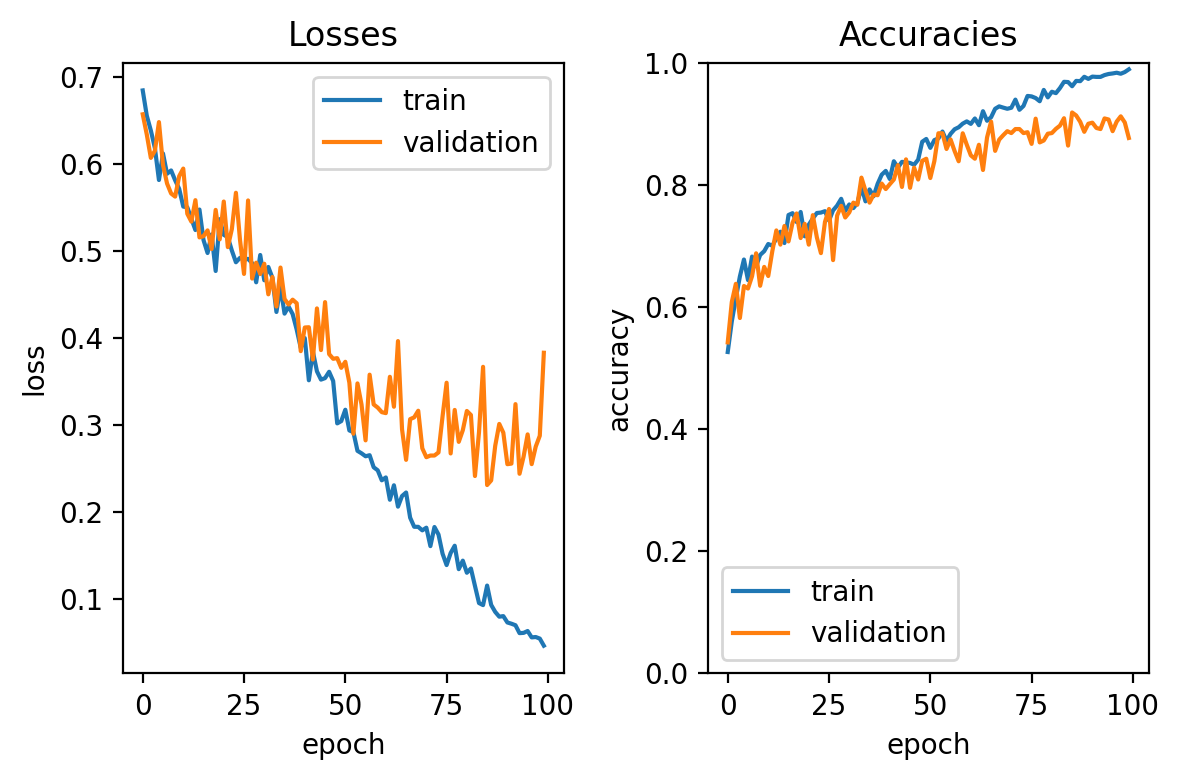

In [41]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations. 

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
`put your answer here`

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [42]:
if N_EPOCHS == 0:
  saved_model_path = Path(
    '/home/ekka/Programming/courses/pytorch-Deep-Learning/'
    'Assignments/Homework2/models/20220930-153252.pt')
  model.load_state_dict(torch.load(saved_model_path))
  model.eval()

test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=BATCH_SIZE, num_workers=4)
total_test_loss = []
total_test_correct = []

with torch.no_grad():
    for batch in test_dataloader:
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        total_test_loss.append(loss)
        total_test_correct.append(correct)

mean_test_loss = torch.FloatTensor(total_test_loss).cpu().mean().item()
test_accuracy = torch.FloatTensor(total_test_correct).cpu().mean().item()
print(f'test_loss: {mean_test_loss} test_accuracy: {test_accuracy}')


test_loss: 0.3504389226436615 test_accuracy: 0.8795139193534851


### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

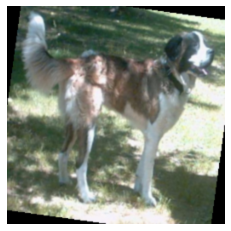

In [43]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation. 
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



In [44]:
def plot_intermediate_output(result, title, x, y, height, width):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert x + height <= N
  assert y + width <= M
  assert N * M >= n_filters
  
  fig, axs = plt.subplots(height, width)
  fig.suptitle(title)
  
  for i in range(x, x+height):
    for j in range(y, y+width):
      if i*N + j < n_filters:
        #axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i-x][j-y].imshow(result[0, i*N + j].cpu().detach())
        axs[i-x][j-y].axis('off')
        #plt.imshow(result[0, i*N + j].cpu().detach())

Output shape:torch.Size([1, 32, 128, 128]) width:5


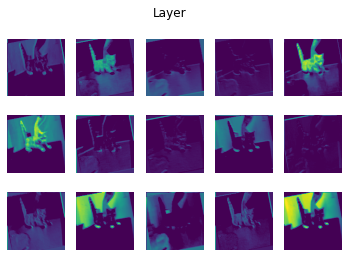

In [45]:
clipped = nn.Sequential(
  *list(model.children())[:1]
)
#print(list(model.children()))

input = train_dataset[0][0].unsqueeze(0)
output = clipped(input.to(device))
width = int(math.sqrt(output.shape[1]))
print(f'Output shape:{output.shape} width:{width}')
plot_intermediate_output(output, 'Layer', 0, 0, 3, 5)
# TODO: 
# pick a few intermediate representations from your network and plot them using 
# the provided function.

In [46]:
file_dir = Path(f'{os.getcwd()}/models')
file_dir.mkdir(parents=True, exist_ok=True)
file_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.pt'
save_path = file_dir / file_name 
#torch.save(model.state_dict(), save_path)

#torch.save(model.state_dict, )

What can you say about those filters? What features are they focusing on?

Anwer: `Your answer here`